In [1]:
import numpy as np
import nibabel as nib
import dsiadapt as dsi
from dipy.viz import fvtk
import dipy.core.gradients as grad
from dipy.data import get_sphere
from dipy.direction import peaks_from_model

%pylab inline
np.set_printoptions(threshold=numpy.nan)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# ODF sphere directions
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.0

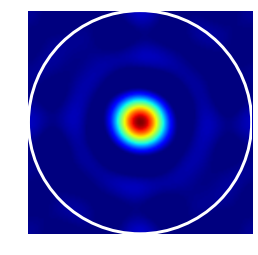

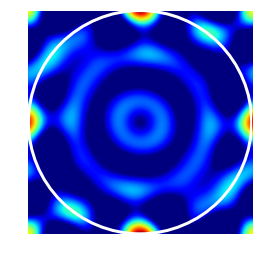

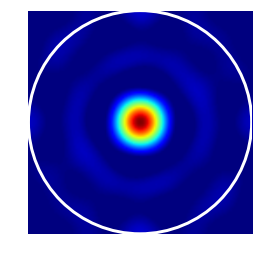

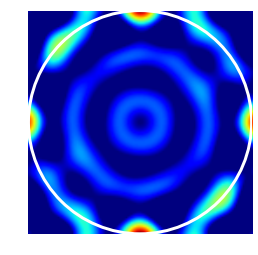

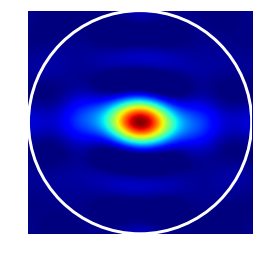

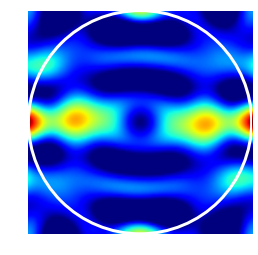

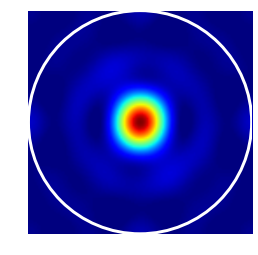

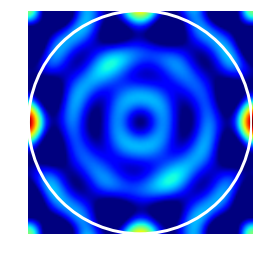

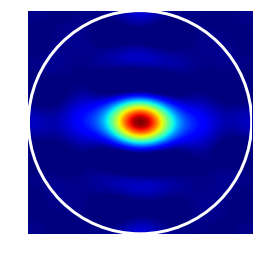

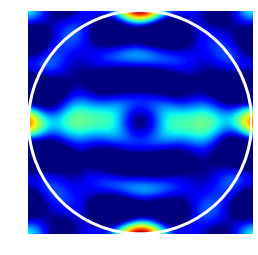

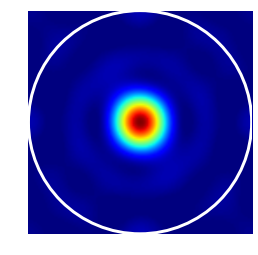

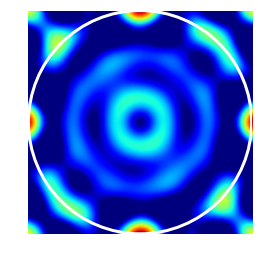

In [3]:
fnArr = np.array(['DSI11_exvivo', 'DSI11_invivo_b10k', 'DSI11_invivo_b7k'])
#fnArr = np.array(['DSI11_invivo_b10k'])

fibArr = np.array(['cc', 'xfib']) 
#fibArr = np.array(['xfib']) 

wintypeArr = np.array(['none']);

qgridsz = 129; # Q-space grid size
qgridcenter = qgridsz//2;
pdfwgtorder = 2;

for ii in np.arange(fnArr.shape[0]):
    fn = fnArr[ii];
    gtab = grad.gradient_table('data/' + fn + '_bvals.txt', 'data/' + fn + '_bvecs_dipy.txt');
    mdd = np.loadtxt('data/' + fn + '_stats.txt')[0];
    fov = np.loadtxt('data/' + fn + '_stats.txt')[1];
    winwidth = 2. * dsi.create_qtable(gtab).max();
    intdistArr = np.array([fov/2, fov/2, fov/2, fov/2, mdd]); 

    for jj in np.arange(fibArr.shape[0]):
        fib = fibArr[jj];
        data = nib.load('data/' + fn + '_' + fib + '.nii.gz').get_data();
        
        for kk in np.arange(wintypeArr.shape[0]):
            wintype = wintypeArr[kk];
            intdist = intdistArr[kk];   
            rend = intdist / fov * qgridsz;
            
            dsimodel = dsi.DiffusionSpectrumModel(gtab, qgrid_size=qgridsz, filter_width=winwidth, filter_type=wintype, r_start=0, r_end=rend, r_step=0.2);
            dsifit = dsimodel.fit(data);
            
            # ODF
            #odf = dsifit.odf(sphere, pdfwgtorder);
            #odfvox = odf[2, 0, 0]
            
            # ODF peaks
            dsipeaks = peaks_from_model(dsimodel, data[2, 0, 0], sphere,
                             relative_peak_threshold=.2,
                             min_separation_angle=25, normalize_peaks=True, return_odf=True)
            odfvox = dsipeaks.odf;
            
            # PDF
            pdf = dsifit.pdf(normalized=False, clipped=False); 
            pdfvox = pdf[2, 0, 0]

            pdfvox = pdfvox / pdfvox.max()
            pdfslice = np.fliplr(np.rot90(pdfvox[:, qgridcenter, :]))
            pdfslice_clipped = np.clip(pdfslice, 0, pdfslice.max())
            
            # Weighted PDF
            pdf_weighted = dsifit.pdf_weighted(); 
            pdfvox_weighted = pdf_weighted[2, 0, 0]
            
            pdfvox_weighted = pdfvox_weighted / pdfvox_weighted.max()
            pdfslice_weighted = np.fliplr(np.rot90(pdfvox_weighted[:, qgridcenter, :]))
            pdfslice_weighted_clipped = np.clip(pdfslice_weighted, 0, pdfslice_weighted.max())

            # Save ODF
            r = fvtk.ren();
            fvtk.add(r, fvtk.sphere_funcs(odfvox, sphere));
            fvtk.camera(r, pos=(0, 1, 0), viewup=(0, 0, 1))
            odfname = 'figure3/' + fn + '_' + fib + '_odf_' + wintype + '_rend_' + str(rend) + '.png';
            fvtk.record(r, n_frames=1, out_path=odfname, size=(600,600))
            #fvtk.show(r)
            
            # Save ODF peaks
            r = fvtk.ren();
            fvtk.add(r, fvtk.peaks(dsipeaks.peak_dirs, dsipeaks.peak_values, scale=2.2))
            fvtk.camera(r, pos=(0, 1, 0), viewup=(0, 0, 1))
            odfpeaksname = 'figure3/' + fn + '_' + fib + '_odfpeaks_' + wintype + '_rend_' + str(rend) + '.png';
            fvtk.record(r, n_frames=1, out_path=odfpeaksname, size=(600,600))
            #fvtk.show(r)

            # Save PDF
            fig = figure()
            imshow(pdfslice_clipped);
            circle = Circle((qgridsz//2, qgridsz//2), radius = rend, color = 'w', fill=False, linestyle = 'solid', linewidth=3.)
            fig.gca().add_artist(circle)
            axis('off');
            pdfname = 'figure3/' + fn + '_' + fib + '_pdf_' + wintype + '_rend_' + str(rend) + '.png';
            savefig(pdfname, dpi = 600)

            # Save weighted PDF
            fig = figure()
            imshow(pdfslice_weighted_clipped);
            circle = Circle((qgridsz//2, qgridsz//2), radius = rend, color = 'w', fill=False, linestyle = 'solid', linewidth=3.)
            fig.gca().add_artist(circle)
            axis('off');
            pdfname = 'figure3/' + fn + '_' + fib + '_weightedpdf_' + wintype + '_rend_' + str(rend) + '.png';
            savefig(pdfname, dpi = 600)
